In [ ]:
import os
import Augmentor

# Define the base directory where the subfolders are located
base_directory = r"E:\Research\\components"

# Loop through all 15 folders
for i in range(1, 5):
    # Define the path for the current folder using os.path.join
    folder_name = str(i)
    folder_path = os.path.join(base_directory, folder_name)
    
    # Check if the folder exists
    if os.path.exists(folder_path):
        # Create an Augmentor pipeline for image augmentation
        p = Augmentor.Pipeline(folder_path)
        
        # Add augmentation operations as needed
        p.zoom(probability=0.6, min_factor=0.75, max_factor=1)
        p.flip_top_bottom(probability=0.5)
        p.flip_left_right(probability=0.5)
        p.rotate(probability=1, max_left_rotation=25, max_right_rotation=25)
        p.rotate_random_90(probability=1)
        p.random_brightness(probability=0.5, min_factor=0.4, max_factor=0.9)
        p.random_distortion(probability=0.5, grid_width=7, grid_height=8, magnitude=9)
        p.random_erasing(probability=0.3, rectangle_area=0.2)
        
        # Sample the augmented images (generate 150 augmented images for each folder)
        p.sample(150)
    else:
        print(f"Folder {folder_name} does not exist at {folder_path}")

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define the root directory containing subfolders for each image class
data_dir = 'E:\Research\data'
batch_size = 32
image_size = (224, 224)  # Adjust the size as needed

# Use the ImageDataGenerator to load and preprocess images
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    validation_split=0.2,  # Split the data into training and validation sets
)

# Create a training dataset
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    subset='training',  # Specify 'training' to create the training dataset
    shuffle=True,  # Shuffle the data
)

# Create a validation dataset
val_data = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    subset='validation',  # Specify 'validation' to create the validation dataset
    shuffle=False,  # Do not shuffle the validation data
)

# Optionally, you can create a test dataset in a similar way
# test_data = datagen.flow_from_directory(
#     'test_data_dir',
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='categorical',  # Use 'categorical' for multi-class classification
#     shuffle=False,  # Do not shuffle the test data
# )

# You can now use train_data and val_data for training and validation in your machine learning model.

Found 54948 images belonging to 3 classes.
Found 13737 images belonging to 3 classes.


In [2]:
import numpy as np
import cv2 as cv
from glob import glob
from tqdm import tqdm

# Initialize data and label lists
data_list = []
label_list = []

# Define the shape for resizing
image_shape = (32, 32)

# Function to convert an image to an array
def img_to_arr(add, shape):
    image = cv.imread(add)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, shape)
    image = image.astype("float32") / 255
    return image

for i in range(1, 16):
    print('Extracting patches for Component ' + str(i))
    path = 'E:\\Research\\data\\train\\' + str(i) + '\\'
    type_1 = glob(path + '*.bmp')

    for image_path in tqdm(type_1):
        image = img_to_arr(image_path, image_shape)
        data_list.append(image)
        label_list.append(i)

data = np.stack(data_list, axis=0)  # Convert the list of images to a NumPy array
labels = np.array(label_list)

# Save the data and labels
np.save('E:\\Research\\test\\data_32.npy', data)
np.save('E:\\Research\\test\\labels.npy', labels)


Extracting patches for Component 1


100%|██████████| 5036/5036 [01:55<00:00, 43.70it/s]


Extracting patches for Component 2


100%|██████████| 5000/5000 [01:14<00:00, 66.72it/s] 


Extracting patches for Component 3


100%|██████████| 5250/5250 [01:16<00:00, 68.23it/s]


Extracting patches for Component 4


100%|██████████| 5244/5244 [01:43<00:00, 50.87it/s]


Extracting patches for Component 5


100%|██████████| 4250/4250 [01:43<00:00, 41.21it/s]


Extracting patches for Component 6


100%|██████████| 4000/4000 [01:18<00:00, 51.15it/s]


Extracting patches for Component 7


100%|██████████| 1250/1250 [00:18<00:00, 69.33it/s]


Extracting patches for Component 8


100%|██████████| 4250/4250 [01:03<00:00, 66.89it/s]


Extracting patches for Component 9


100%|██████████| 5588/5588 [01:30<00:00, 62.03it/s]


Extracting patches for Component 10


100%|██████████| 5388/5388 [01:54<00:00, 46.92it/s]


Extracting patches for Component 11


100%|██████████| 6250/6250 [01:10<00:00, 88.60it/s] 


Extracting patches for Component 12


100%|██████████| 250/250 [00:02<00:00, 94.95it/s] 


Extracting patches for Component 13


100%|██████████| 5713/5713 [01:23<00:00, 68.22it/s] 


Extracting patches for Component 14


100%|██████████| 4566/4566 [01:15<00:00, 60.58it/s] 


Extracting patches for Component 15


100%|██████████| 3500/3500 [01:13<00:00, 47.44it/s]


In [2]:
import numpy as np
import cv2 as cv
from glob import glob
from tqdm import tqdm

data = np.empty((32, 32))  
label = []

def img_to_arr(add, shape):
    image = cv.imread(add)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, shape)
    image = image.astype("float32") / 255
    return np.array(image)

for i in range(1, 5):
    print('Extracting patches for Component' + str(i))
    path = 'E:\Research\components' + str(i) + '/'
    type_1 = glob(path + '*.bmp')

    for j in tqdm(range(len(type_1))):
        image = img_to_arr(type_1[j], [32, 32])
        data = np.dstack([data, image])
        label.append(i)

Extracting patches for Component1


0it [00:00, ?it/s]


Extracting patches for Component2


0it [00:00, ?it/s]


Extracting patches for Component3


0it [00:00, ?it/s]


Extracting patches for Component4


0it [00:00, ?it/s]


In [3]:

def img_to_arr(add, shape):
  image = cv.imread(add)
  image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  image = cv.resize(image,shape)
  image=image.astype("float32") / 255
  #image = image/255.0
  #image = image.reshape((1,shape[0]*shape[1]))
  return (np.array(image))

for i in range(1,16):
  print('Extracting patches for '+str(i))
  path='E:\Research\\test'+ str(i)+'/'
  type_1 = glob(path+'*.bmp')
  for j in tqdm(range(len(type_1))):
    image=img_to_arr(type_1[j],[32,32])
    data=np.dstack([data,image])
    label.append(i)

Extracting patches for 1


0it [00:00, ?it/s]


Extracting patches for 2


0it [00:00, ?it/s]


Extracting patches for 3


0it [00:00, ?it/s]


Extracting patches for 4


0it [00:00, ?it/s]


Extracting patches for 5


0it [00:00, ?it/s]


Extracting patches for 6


0it [00:00, ?it/s]


Extracting patches for 7


0it [00:00, ?it/s]


Extracting patches for 8


0it [00:00, ?it/s]


Extracting patches for 9


0it [00:00, ?it/s]


Extracting patches for 10


0it [00:00, ?it/s]


Extracting patches for 11


0it [00:00, ?it/s]


Extracting patches for 12


0it [00:00, ?it/s]


Extracting patches for 13


0it [00:00, ?it/s]


Extracting patches for 14


0it [00:00, ?it/s]


Extracting patches for 15


0it [00:00, ?it/s]


In [3]:
import numpy as np

data_1 = None  # Initialize as None
label1 = []

for i in range(1, 16):
    print('Combining features for ' + str(i))
    
    if i == 14:
        data2 = np.load('E:\\Research\\test\\data_32_' + str(i) + '.npy')
        label2 = np.load('E:\\Research\\test\\labels_32_' + str(i) + '.npy')
        
        if data_1 is None:
            data_1 = data2
        else:
            if data_1.shape[2] == data2.shape[2]:
                data_1 = np.dstack([data_1, data2])
            else:
                print(f"Dimensions don't match for Component {i}. Skipping.")
        
        for j in label2:
            label1.append(j)

# Ensure data_1 has 3 dimensions (height, width, num_samples)
if data_1 is not None and data_1.ndim == 2:
    data_1 = data_1[:, :, np.newaxis]

# Save the combined data and labels
if data_1 is not None:
    np.save('E:\\Research\\test\\fulldata_32.npy', data_1)
if label1:
    np.save('E:\\Research\\test\\fulllabels_32.npy', label1)


Combining features for 1
Combining features for 2
Combining features for 3
Combining features for 4
Combining features for 5
Combining features for 6
Combining features for 7
Combining features for 8
Combining features for 9
Combining features for 10
Combining features for 11
Combining features for 12
Combining features for 13
Combining features for 14
Combining features for 15


In [1]:
import numpy as np

data_1 = None  # Initialize as None
label1 = []

for i in range(1, 16):
    print('Combining features for ' + str(i))
    
    if i == 14:
        data2 = np.load('E:\\Research\\test\\data_32_' + str(i) + '.npy')
        label2 = np.load('E:\\Research\\test\\labels_32_' + str(i) + '.npy')
        
        if data_1 is None:
            data_1 = data2
        else:
            if data_1.shape[2] == data2.shape[2]:
                data_1 = np.dstack([data_1, data2])
            else:
                print(f"Dimensions don't match for Component {i}. Skipping.")
        
        for j in label2:
            label1.append(j)

# Ensure data_1 has 3 dimensions (height, width, num_samples)
if data_1 is not None and data_1.ndim == 2:
    data_1 = data_1[:, :, np.newaxis]

# Print label1 to check if it's correctly populated
print(label1)

# Save the combined data and labels
if data_1 is not None:
    np.save('E:\\Research\\test\\fulldata_32.npy', data_1)
if label1:
    np.save('E:\\Research\\test\\fulllabels_32.npy', label1)


Combining features for 1
Combining features for 2
Combining features for 3
Combining features for 4
Combining features for 5
Combining features for 6
Combining features for 7
Combining features for 8
Combining features for 9
Combining features for 10
Combining features for 11
Combining features for 12
Combining features for 13
Combining features for 14
Combining features for 15
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [16]:
import os
from PIL import Image

def check_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()  # Check for image validity
        return True
    except (IOError, SyntaxError):
        return False

def remove_faulty_images(root_folder):
    for subfolder in os.listdir(root_folder):
        subfolder_path = os.path.join(root_folder, subfolder)
        if os.path.isdir(subfolder_path):
            print(f"Checking subfolder: {subfolder}")
            for filename in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, filename)
                if os.path.isfile(file_path) and check_image(file_path):
                    try:
                        if not check_image(file_path):
                            os.remove(file_path)
                            print(f"Removed faulty image: {filename} from {subfolder}")
                    except PermissionError as e:
                        print(f"Permission denied: {e} - Skipping file: {filename}")
                else:
                    print(f"Skipped non-image file: {filename} from {subfolder}")

# Replace 'root_folder' with the path to your dataset's main folder containing the 15 subfolders.
dataset_root = 'E:\\Research\\data\\train'
remove_faulty_images(dataset_root)


Checking subfolder: 1
Skipped non-image file: output from 1
Checking subfolder: 10
Skipped non-image file: output from 10
Checking subfolder: 11
Checking subfolder: 12
Skipped non-image file: output from 12
Checking subfolder: 13
Skipped non-image file: output from 13
Checking subfolder: 14
Skipped non-image file: output from 14
Checking subfolder: 15
Skipped non-image file: output from 15
Checking subfolder: 2
Skipped non-image file: output from 2
Checking subfolder: 3
Skipped non-image file: output from 3
Checking subfolder: 4
Skipped non-image file: output from 4
Checking subfolder: 5
Skipped non-image file: output from 5
Checking subfolder: 6
Checking subfolder: 7
Skipped non-image file: output from 7
Checking subfolder: 8
Skipped non-image file: output from 8
Checking subfolder: 9
Skipped non-image file: output from 9


In [2]:
from sklearn.model_selection import train_test_split
import numpy as np

# Load data and labels
data_1 = np.load('E:\\Research\\test\\data_32_14.npy')
label = np.load('E:\\Research\\test\\labels_32_14.npy')

# Reshape the data (assuming the shape is (num_samples, height, width))
data_1 = data_1.reshape(data_1.shape[0], 32, 32, 1)

label = label - 1

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data_1, label, test_size=0.4, random_state=10, stratify=label)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10, stratify=y_temp)


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define your model suitable for 32x32 input images
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(15, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with your data
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# After training, use the model to predict
y_pred = model.predict(X_test)


Epoch 1/10
1229/1229 [==============================] - 55s 42ms/step - loss: 1.8459 - accuracy: 0.3979 - val_loss: 1.5374 - val_accuracy: 0.4967
Epoch 2/10
1229/1229 [==============================] - 56s 46ms/step - loss: 1.3160 - accuracy: 0.5666 - val_loss: 1.3548 - val_accuracy: 0.5570
Epoch 3/10
1229/1229 [==============================] - 53s 43ms/step - loss: 1.0479 - accuracy: 0.6491 - val_loss: 1.2898 - val_accuracy: 0.5811
Epoch 4/10
1229/1229 [==============================] - 64s 52ms/step - loss: 0.8344 - accuracy: 0.7209 - val_loss: 1.2929 - val_accuracy: 0.5927
Epoch 5/10
1229/1229 [==============================] - 129s 105ms/step - loss: 0.6524 - accuracy: 0.7818 - val_loss: 1.3711 - val_accuracy: 0.5888
Epoch 6/10
1229/1229 [==============================] - 41s 34ms/step - loss: 0.4961 - accuracy: 0.8352 - val_loss: 1.5278 - val_accuracy: 0.5762
Epoch 7/10
1229/1229 [==============================] - 41s 33ms/step - loss: 0.3678 - accuracy: 0.8807 - val_loss: 1.6454

Epoch 1/10
154/154 [==============================] - 150s 946ms/step - loss: 0.3318 - accuracy: 0.8834 - val_loss: 0.3809 - val_accuracy: 0.8708
Epoch 2/10
154/154 [==============================] - 124s 803ms/step - loss: 0.3045 - accuracy: 0.8938 - val_loss: 0.3856 - val_accuracy: 0.8702
Epoch 3/10
154/154 [==============================] - 104s 677ms/step - loss: 0.3007 - accuracy: 0.8930 - val_loss: 0.3784 - val_accuracy: 0.8740
Epoch 4/10
154/154 [==============================] - 114s 742ms/step - loss: 0.2865 - accuracy: 0.8981 - val_loss: 0.3742 - val_accuracy: 0.8750
Epoch 5/10
154/154 [==============================] - 113s 735ms/step - loss: 0.2752 - accuracy: 0.9029 - val_loss: 0.3743 - val_accuracy: 0.8778
Epoch 6/10
154/154 [==============================] - 110s 715ms/step - loss: 0.2602 - accuracy: 0.9070 - val_loss: 0.3826 - val_accuracy: 0.8767
Epoch 7/10
154/154 [==============================] - 94s 613ms/step - loss: 0.2568 - accuracy: 0.9080 - val_loss: 0.3918 - 

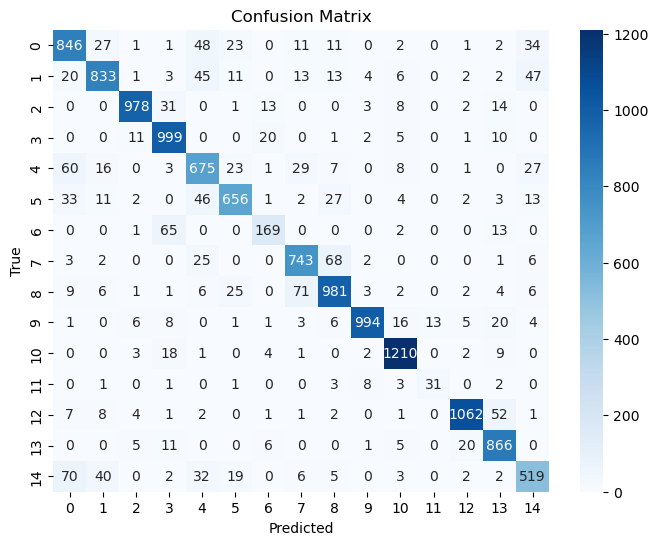

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.image import resize
import tensorflow as tf

# Resize your test images to 256x256
X_test_resized = resize(X_test, (256, 256), method='bilinear')
model.compile(optimizer='Adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
#model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
#history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_split=.2)
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_val,y_val))
# Assuming you have predictions in y_pred (replace with your actual predictions)
y_pred = model.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/10


d:\anaconda\lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


154/154 [==============================] - 33s 189ms/step - loss: 1.8318 - accuracy: 0.4210 - val_loss: 1.6260 - val_accuracy: 0.4675
Epoch 2/10
154/154 [==============================] - 24s 153ms/step - loss: 1.5181 - accuracy: 0.4961 - val_loss: 1.4969 - val_accuracy: 0.4967
Epoch 3/10
154/154 [==============================] - 21s 135ms/step - loss: 1.3654 - accuracy: 0.5442 - val_loss: 1.4244 - val_accuracy: 0.5232
Epoch 4/10
154/154 [==============================] - 61s 396ms/step - loss: 1.2542 - accuracy: 0.5779 - val_loss: 1.3777 - val_accuracy: 0.5367
Epoch 5/10
154/154 [==============================] - 84s 544ms/step - loss: 1.1537 - accuracy: 0.6108 - val_loss: 1.3674 - val_accuracy: 0.5428
Epoch 6/10
154/154 [==============================] - 78s 506ms/step - loss: 1.0710 - accuracy: 0.6377 - val_loss: 1.3674 - val_accuracy: 0.5444
Epoch 7/10
154/154 [==============================] - 57s 371ms/step - loss: 0.9944 - accuracy: 0.6653 - val_loss: 1.3736 - val_accuracy: 0.5

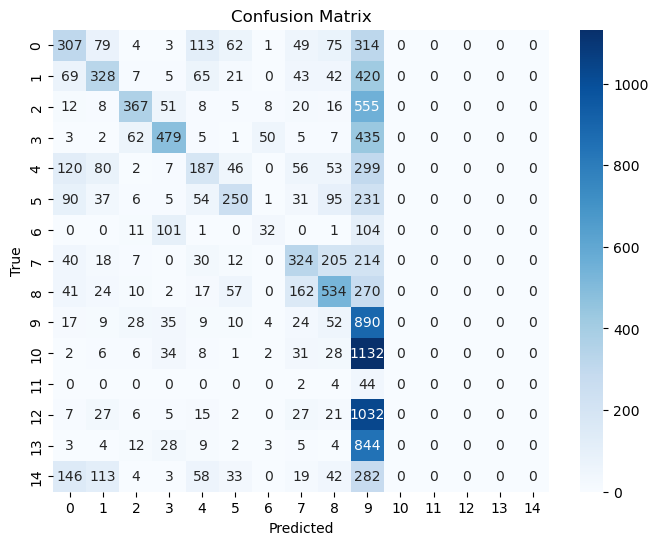

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# Clip the labels to the range [0, 9]
y_train_clipped = np.clip(y_train, 0, 9)
y_val_clipped = np.clip(y_val, 0, 9)

from tensorflow.keras.layers import Conv2D, Flatten

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    # Add more layers as needed
    Flatten(),
    Dense(64, activation='relu'),
    Dense(20, activation='softmax')
])


# Compile the model
model.compile(optimizer='Adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model with clipped labels
history = model.fit(X_train, y_train_clipped, epochs=10, batch_size=256,
                    validation_data=(X_val, y_val_clipped), callbacks=[early_stop])

# Get predictions on test data
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [7]:
import numpy as np
import os

# Load data and labels
data_1 = np.load('E:\\Research\\test\\data_32_14.npy')
label = np.load('E:\\Research\\test\\labels_32_14.npy')

# Define your criteria for identifying faulty images
def is_faulty_image(image):
    # Implement your criteria here
    # For example, you can check if the image content is faulty
    # or based on other properties of the image.

    # Here's an example that assumes faulty images have very low mean intensity:
    return np.mean(image) < 0.1  # Adjust the threshold as needed

# Create a folder to store non-faulty images
output_folder = 'E:\\Research\\test\\non_faulty_images'
os.makedirs(output_folder, exist_ok=True)

# Iterate through the images and labels, and keep non-faulty images
non_faulty_data = []
non_faulty_labels = []

for image, label_value in zip(data_1, label):
    if not is_faulty_image(image):
        non_faulty_data.append(image)
        non_faulty_labels.append(label_value)

# Convert lists to NumPy arrays
non_faulty_data = np.array(non_faulty_data)
non_faulty_labels = np.array(non_faulty_labels)

# Save the non-faulty data and labels
np.save('E:\\Research\\test\\non_faulty_data_32.npy', non_faulty_data)
np.save('E:\\Research\\test\\non_faulty_labels.npy', non_faulty_labels)

# Clean up: Delete the original data and labels files
# os.remove('E:\\Research\\test\\data_32.npy')
# os.remove('E:\\Research\\test\\labels.npy')


In [8]:
# Assuming you have already trained your model and X_test contains test data
# Get predictions from your trained model
y_pred_labels = model.predict(X_test)

# Now you can print the shape and unique values of y_test and y_pred_labels
print(f"y_test shape: {y_test.shape}, unique values: {np.unique(y_test)}")
print(f"y_pred_labels shape: {y_pred_labels.shape}, unique values: {np.unique(y_pred_labels)}")

# Convert one-hot encoded predictions to class labels
y_pred_class_labels = np.argmax(y_pred_labels, axis=1)

# Now, y_pred_class_labels should contain the predicted class labels
print(f"y_pred_class_labels shape: {y_pred_class_labels.shape}, unique values: {np.unique(y_pred_class_labels)}")


410/410 [==============================] - 3s 7ms/step
y_test shape: (13107,), unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
y_pred_labels shape: (13107, 20), unique values: [2.4104368e-23 2.5132148e-23 3.1488137e-23 ... 9.9999952e-01 9.9999988e-01
 1.0000000e+00]
y_pred_class_labels shape: (13107,), unique values: [0 1 2 3 4 5 6 7 8 9]


In [10]:
data_1 = np.load('E:\\Research\\test\\data_32_14.npy')
print(data_1.shape)

(65535, 32, 32)


In [11]:
# Create CNN model
import tensorflow as tf
import keras
from keras import datasets, layers, models
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32,32,1)))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(Dropout(0.50))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

#model.add(Dropout(0.50))
model.add(layers.Flatten())
model.add(layers.Dense(1024,  activation='relu'))
#model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(15, activation='softmax'))
# Compile model
#opt = keras.optimizers.Adam(learning_rate=0.0001)

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      

In [12]:
model.compile(optimizer='Adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
#model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
#history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_split=.2)
history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_val,y_val))

Epoch 1/20
154/154 [==============================] - 168s 1s/step - loss: 2.1743 - accuracy: 0.2691 - val_loss: 1.5732 - val_accuracy: 0.4712
Epoch 2/20
154/154 [==============================] - 135s 879ms/step - loss: 1.4635 - accuracy: 0.4945 - val_loss: 1.1557 - val_accuracy: 0.6080
Epoch 3/20
154/154 [==============================] - 141s 918ms/step - loss: 1.1536 - accuracy: 0.5933 - val_loss: 0.9067 - val_accuracy: 0.6923
Epoch 4/20
154/154 [==============================] - 137s 891ms/step - loss: 0.9739 - accuracy: 0.6546 - val_loss: 0.7970 - val_accuracy: 0.7301
Epoch 5/20
154/154 [==============================] - 113s 736ms/step - loss: 0.8491 - accuracy: 0.7022 - val_loss: 0.7291 - val_accuracy: 0.7535
Epoch 6/20
154/154 [==============================] - 111s 718ms/step - loss: 0.7660 - accuracy: 0.7309 - val_loss: 0.6745 - val_accuracy: 0.7711
Epoch 7/20
154/154 [==============================] - 108s 704ms/step - loss: 0.6985 - accuracy: 0.7531 - val_loss: 0.6162 - va

410/410 - 9s - loss: 0.3951 - accuracy: 0.8683 - 9s/epoch - 21ms/step


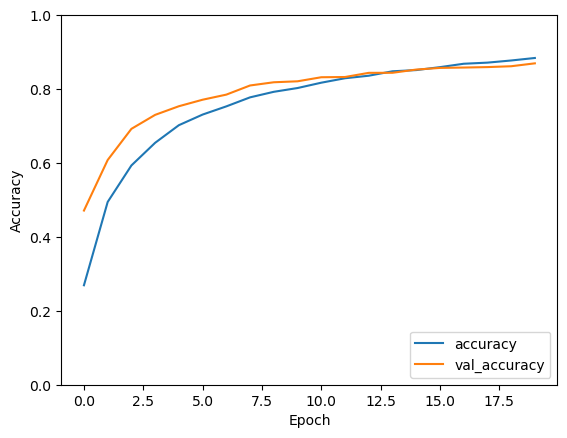

In [13]:
import matplotlib.pyplot as pl
pl.plot(history.history['accuracy'], label='accuracy')
pl.plot(history.history['val_accuracy'], label = 'val_accuracy')
pl.xlabel('Epoch')
pl.ylabel('Accuracy')
pl.ylim([0, 1])
pl.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2) 